In [1]:
import matplotlib.pyplot as plt
import numpy as np
import casperfpga
import time
from lwa_f import snap2_fengine
import pandas as pd
from cr_functions import *
import struct
import math
from scipy import special as sp
from scipy import optimize as oz
from scipy import stats as st

# Theoretical Expectations for Thermal Noise
There are $k$ antennas whose voltage timeseries is described by independent Gaussian noise with variance $\sigma^2$ and mean $\mu$ (which will usually be zero, but I'm keeping it general here). A trigger occurs if at least $n$ of these $k$ timeseries exceeds a threshold $v$ within a time window of $w$ samples.

First consider and individual antenna's voltage timeseries.
The probability that the absolute value of any sample in an individual timeseries exceeds $v$ is:
$$ F(v) = 1 - \frac{1}{2}[\rm{erf}(\dfrac{v+\mu}{\sigma \sqrt{2}}) + \rm{erf}(\dfrac{v-\mu}{\sigma \sqrt{2}})] $$
(see paper notebook pages 26-27 for derivation)

The probability that at least one sample exceeds the threshold is the compliment of the probability that none of the samples exceed the threshold.  Let $b$ be the probability of at least one threshold excess within the window w.

$$ b = 1- (1-F(v))^w $$

Now consider that there are $k$ antennas with independant Gaussian-distributed timeseries.  The probability $P$ that $x$ of those $k$ antennas exceeds a threshold within a window is described by a binomial distribution because for each antenna there are two possible outcomes: cross the threshold within the window or never cross the threshold within the window.

$$ P(x | k, b) = \dfrac{k!}{x!(k-x)!}b^x(1-b)^{(k-x)}  $$

The probability of a trigger is the probability that $x>=n$.

$$P_{\rm{trigger}}=  \sum_{x=n}^{x=k}(\dfrac{k!}{x!(k-x)!}b^x(1-b)^{(k-x)}) $$

This assumes that b is the same for all the antennas. In reality, different antennas will have different standard deviations. However, the above still works if different values of v are chosen for each antenna such that b is the same for all.

Now, I can calculate $P_{trigger}$ as a function of $w$, $n$, $k$, $v$, $sigma$ and $\mu$.

In [12]:
def Ptrigger(w,n,k,sig,mu,v):
    #returns the probability of a coincident trigger in which at least n out of k antennas cross a threshold v within window length w 
    #where all the antennas voltage timeseries are independant and are Gaussian distributed with the same mean mu and standard deviation k
    Fv =1 - 0.5*(sp.erf((v + mu)/((2**0.5)*sig)) + sp.erf((v - mu)/((2**0.5)*sig)))
    b = 1- (1-Fv)**w
    
    p=0
    for x in range(n,k+1):
        kchoosx = (math.factorial(k)/(math.factorial(x)*math.factorial(k-x)))
        px = kchoosx*(b**x)*(1-b)**(k-x)
        p+=px
    return p


In [13]:
mu=0
w=100
n=5
k=64
sig=20
v=80
print(Ptrigger(w,n,k,sig,mu,v))

5.614378860727615e-05


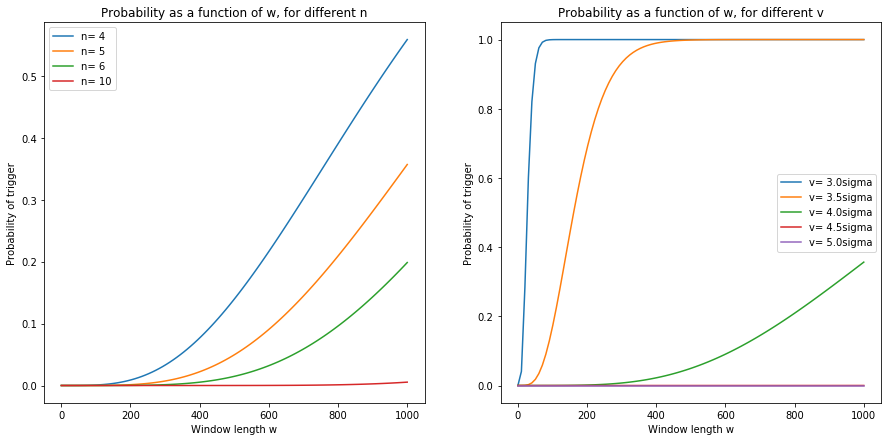

In [45]:
plt.figure(figsize=(15,7))
mu=0
w=100
n=5
k=64
sig=20
v=80
plt.subplot(121)
for n in [4,5,6,10]:
    testvalues  = np.linspace(1,1000,100)
    out = np.zeros(len(testvalues))
    for i,w in enumerate(testvalues):
        out[i] = Ptrigger(w,n,k,sig,mu,v)
    plt.plot(testvalues,out,label='n= '+str(n))
plt.title('Probability as a function of w, for different n')
plt.xlabel('Window length w')
plt.ylabel("Probability of trigger")
plt.legend()

mu=0
w=100
n=5
k=64
sig=20
v=80
plt.subplot(122)
for v in [60,70,80,90,100]:
    testvalues  = np.linspace(1,1000,100)
    out = np.zeros(len(testvalues))
    for i,w in enumerate(testvalues):
        out[i] = Ptrigger(w,n,k,sig,mu,v)
    plt.plot(testvalues,out,label='v= '+str(v/sig)+'sigma')
plt.title('Probability as a function of w, for different v')
plt.xlabel('Window length w')
plt.ylabel("Probability of trigger")
plt.legend()

plt.show()

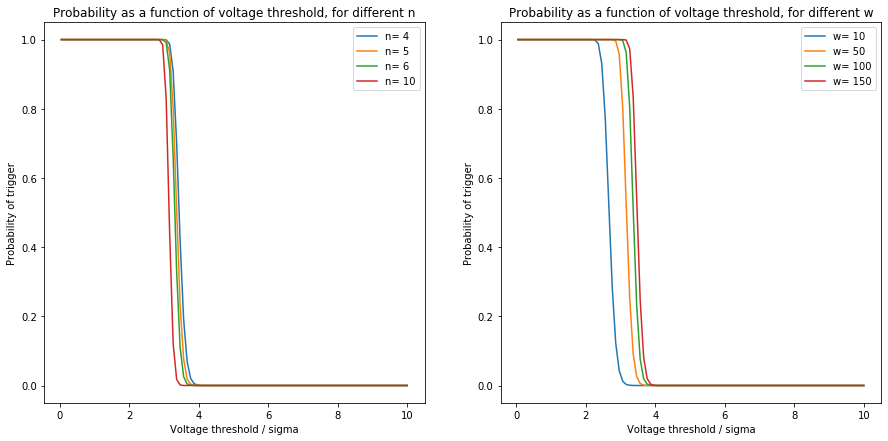

In [48]:
plt.figure(figsize=(15,7))
mu=0
w=100
n=5
k=64
sig=20
v=80
plt.subplot(121)
for n in [4,5,6,10]:
    testvalues  = np.linspace(1,200,100)
    out = np.zeros(len(testvalues))
    for i,v in enumerate(testvalues):
        out[i] = Ptrigger(w,n,k,sig,mu,v)
    plt.plot(testvalues/sig,out,label='n= '+str(n))
plt.title('Probability as a function of voltage threshold, for different n')
plt.xlabel('Voltage threshold / sigma')
plt.ylabel("Probability of trigger")
plt.legend()

mu=0
w=100
n=5
k=64
sig=20
v=80
plt.subplot(122)
for w in [10,50,100,150]:
    testvalues  = np.linspace(1,200,100)
    out = np.zeros(len(testvalues))
    for i,v in enumerate(testvalues):
        out[i] = Ptrigger(w,n,k,sig,mu,v)
    plt.plot(testvalues/sig,out,label='w= '+str(w))
plt.title('Probability as a function of voltage threshold, for different w')
plt.xlabel('Voltage threshold / sigma')
plt.ylabel("Probability of trigger")
plt.legend()

plt.show()

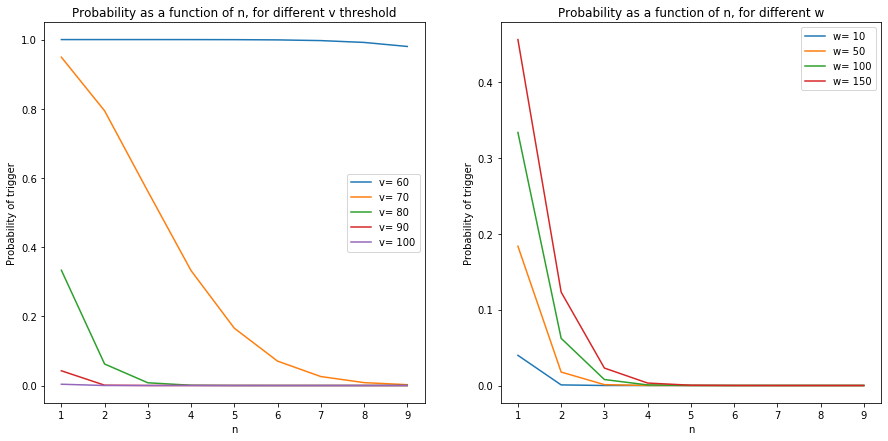

In [59]:
plt.figure(figsize=(15,7))
mu=0
w=100
n=5
k=64
sig=20
v=80
plt.subplot(121)
for v in [60,70,80,90,100]:
    testvalues  = range(1,10)
    out = np.zeros(len(testvalues))
    for i,n in enumerate(testvalues):
        out[i] = Ptrigger(w,n,k,sig,mu,v)
    plt.plot(testvalues,out,label='v= '+str(v))
plt.title('Probability as a function of n, for different v threshold')
plt.xlabel('n')
plt.ylabel("Probability of trigger")
plt.legend()

mu=0
w=100
n=5
k=64
sig=20
v=80
plt.subplot(122)
for w in [10,50,100,150]:
    testvalues  = range(1,10)
    out = np.zeros(len(testvalues))
    for i,n in enumerate(testvalues):
        out[i] = Ptrigger(w,n,k,sig,mu,v)
    plt.plot(testvalues,out,label='w= '+str(w))
plt.title('Probability as a function of n, for different w')
plt.xlabel('n')
plt.ylabel("Probability of trigger")
plt.legend()

plt.show()

## Verify the predictions with python-simulated white noise

In [83]:
def run_trigger(w,n,k,sig,mu,v):
    #generate a white noise timeseries of length w, with mean mu and standard deviation sig, for each of the k antennas
    timeseries = mu + sig*np.random.randn(w,k)

    #count how many antennas had a trigger
    count=0
    for a in range(k):
        applythreshold=np.abs(timeseries[:,a])>v
        this_antenna_triggered = (np.sum(applythreshold))
        if this_antenna_triggered:
            count+=1
    #determine whether enough antennas crossed threshold to trigger
    if count>=n:
        return 1
    else:
        return 0
    
def simulate_ptrigger(w,n,k,sig,mu,v,ntries):
    #estimate the rate the trigger condition is met by simulating white noise timeseries for the specified number of tries
    triggers=0
    for t in range(ntries):
        triggers+=run_trigger(w,n,k,sig,mu,v)
    return (triggers/ntries)

In [84]:
mu=0
w=600
n=4
k=64
sig=20
v=80

ntries=1000
print(simulate_ptrigger(w,n,k,sig,mu,v,ntries))
print(Ptrigger(w,n,k,sig,mu,v))

0.243
0.21603875663300062


In [89]:
mu=0
w=100
n=5
k=64
sig=20
v=80
testvalues  = range(1,10)
computed = np.zeros(len(testvalues))
simulated = np.zeros(len(testvalues))

for i,n in enumerate(testvalues):
    computed[i] = Ptrigger(w,n,k,sig,mu,v)
    simulated[i] = simulate_ptrigger(w,n,k,sig,mu,v,ntries)

(0, 0.002)

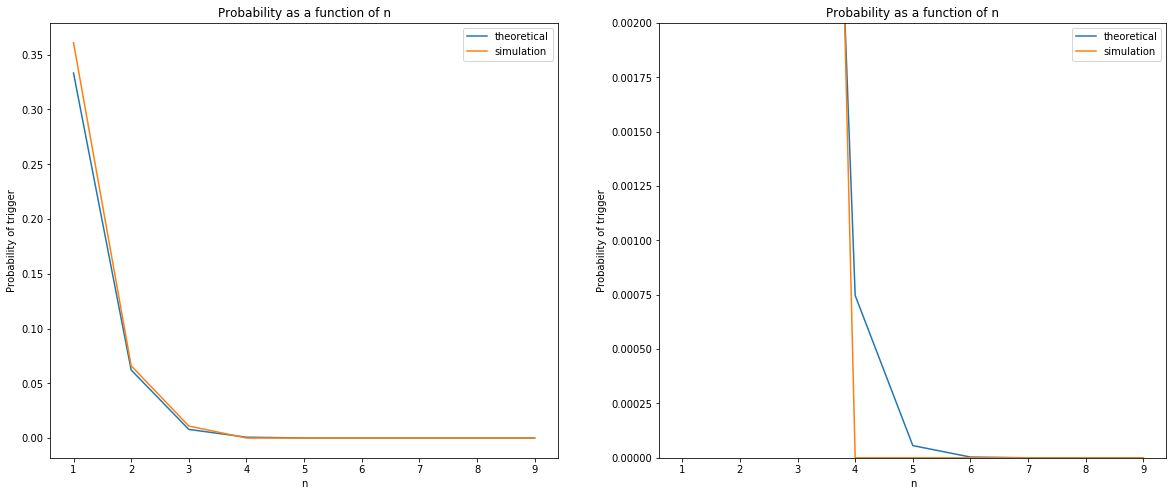

In [92]:
plt.figure(figsize=(20,8))

plt.subplot(121)
plt.plot(testvalues,computed,label='theoretical')
plt.plot(testvalues,simulated,label='simulation')
plt.title('Probability as a function of n')
plt.xlabel('n')
plt.ylabel("Probability of trigger")
plt.legend()

plt.subplot(122)
plt.plot(testvalues,computed,label='theoretical')
plt.plot(testvalues,simulated,label='simulation')
plt.title('Probability as a function of n')
plt.xlabel('n')
plt.ylabel("Probability of trigger")
plt.legend()
plt.ylim(0,0.002)

It becomes more difficult to simulate the low-probability tails because of the number of trials needed, but the simulation above serves as a sanity-check for the calculation.

# First Try at Subbarray Scan
board was already programmed and set up from individual scan notebook

In [125]:
# read core_and_veto_rate BRAM
casperbrd = casperfpga.CasperFpga('snap01', transport=casperfpga.TapcpTransport)


In [138]:
def get_trigger_and_veto_rate(casperbrd):
    byts = casperbrd.read("cosmic_ray_core_and_veto_rate",2*4,0)
    veto = byts[:4]
    core = byts[4:]
    return int.from_bytes(core,'big'), int.from_bytes(veto,'big')

In [139]:
# set all antennas to participate 
setvalue(casperbrd,"trigger_antennas1","cr_registers.xlsx",(2**32)-1)
setvalue(casperbrd,"trigger_antennas2","cr_registers.xlsx",(2**32)-1)




In [141]:
#ns=[5,6,10]
#ws=[10,50,150]
#vs=[150,200,250]
#
#results=[]
#for n in ns:
#    setvalue(casperbrd,"antenna_number_thresh","cr_registers.xlsx",n)#set number threshold
#    for w in ws:
#        setvalue(casperbrd,"trigger_window","cr_registers.xlsx",w)#set window length
#        for v in vs:
#                setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(v**2)) #set voltage threshold
#                time.sleep(2.75)  #have to wait for it to update
#                trigger, veto = get_trigger_and_veto_rate(casperbrd)#read result
#                result = [n,w,v,trigger, veto]
#                results.append(result)

In [143]:
ns=[5,6,10]
ws=[5,50,50]
vs=[150,250,300]

triggerresults=np.zeros((3,3,3))
vetoresults = np.zeros((3,3,3))
narray= np.zeros((3,3,3))
warray=np.zeros((3,3,3))
varray=np.zeros((3,3,3))

for i,n in enumerate(ns):
    setvalue(casperbrd,"antenna_number_thresh","cr_registers.xlsx",n)#set number threshold
    for j,w in enumerate(ws):
        setvalue(casperbrd,"trigger_window","cr_registers.xlsx",w)#set window length
        for k,v in enumerate(vs):
                setvalue(casperbrd,"trigger_power_thresh","cr_registers.xlsx",int(v**2)) #set voltage threshold
                time.sleep(2.75)  #have to wait for it to update
                trigger, veto = get_trigger_and_veto_rate(casperbrd)#read result
                triggerresults[i,j,k]=trigger
                vetoresults[i,j,k]=veto
                narray[i,j,k]=n
                varray[i,j,k]=v
                warray[i,j,k]=w

In [148]:
trigger, veto = get_trigger_and_veto_rate(casperbrd)#read result
print(trigger,veto)
print(np.max(triggerresults))
print(np.max(vetoresults))

4729 0
212370277.0
0.0


[[<matplotlib.lines.Line2D at 0x7f5de55b27d0>],

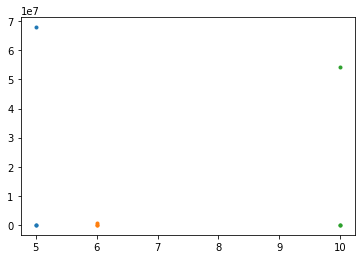

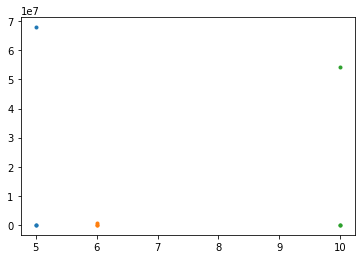

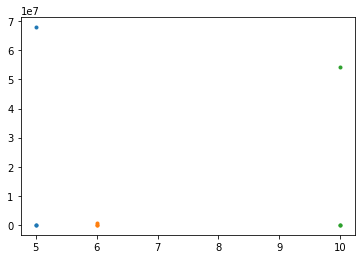

In [152]:
plt.figure()
[plt.plot(narray[l,0,:],triggerresults[l,0,:],'.') for l in range(3)]

plt.figure()
[plt.plot(narray[l,1,:],triggerresults[l,0,:],'.') for l in range(3)]

plt.figure()
[plt.plot(narray[l,2,:],triggerresults[l,0,:],'.') for l in range(3)]

[[<matplotlib.lines.Line2D at 0x7f5de56b3f50>],

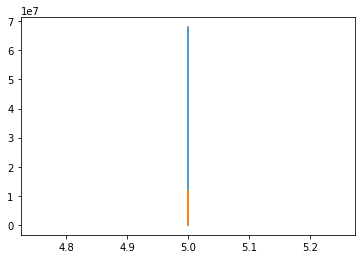

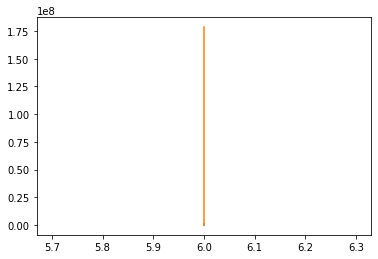

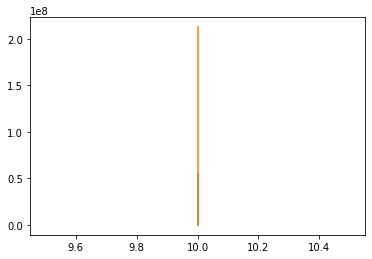

In [150]:
plt.figure()
[plt.plot(narray[0,:,l],triggerresults[0,:,l]) for l in range(3)]

plt.figure()
[plt.plot(narray[1,:,l],triggerresults[1,:,l]) for l in range(3)]

plt.figure()
[plt.plot(narray[2,:,l],triggerresults[2,:,l]) for l in range(3)]